In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cec2017.functions import all_functions
from itertools import chain
from mealpy.swarm_based.PSO import OriginalPSO
from mealpy.bio_based.SMA import OriginalSMA
from mealpy.math_based.CGO import OriginalCGO
from mealpy.physics_based.TWO import OriginalTWO
from mealpy.utils.space import FloatVar

%matplotlib inline

#超参数部分
minx=-100
maxx=100
n_iterations = 500
n_particles =80
inertia=0.8
c1=1.8
c2=2.0
k_eliminate=4
pm=0.06
Original_TWO = OriginalTWO(epoch=n_iterations, pop_size=50)
Original_CGO = OriginalCGO(epoch=n_iterations, pop_size=50)
Original_SMA = OriginalSMA(epoch=n_iterations, pop_size=50, pr=0.03)
Original_PSO = OriginalPSO(epoch=n_iterations, pop_size=n_particles, c1=2.05, c2=2.05)

In [2]:
MyPSO_gbest_history=[]
class Particle:
    def __init__(self, dim, minx, maxx):
        self.position = np.random.uniform(minx, maxx, dim)
        self.velocity = np.random.uniform(-1, 1, size=dim)
        self.pbest_position = self.position.copy()
        self.pbest_score = np.inf
        self.score = np.inf
        self.dim=dim
        
    def update_velocity(self, inertia, c1, c2, gbest_position,repulsive_sources, 
                        repulsion_strength=1.0,attraction_scale=1.0, epilson=1e-6):

        r1 = np.random.rand(self.dim)
        r2 = np.random.rand(self.dim)
        r3 = np.random.rand(self.dim)

        dp = self.pbest_position - self.position
        distance_p = np.linalg.norm(dp)
        # 高斯衰减系数
        cognitive_weight = c1 * np.exp(-distance_p** 2 / (2 * attraction_scale**2))
        cognitive = cognitive_weight * r1* dp 

        dg = gbest_position - self.position
        distance_g = np.linalg.norm(dg)
        social_weight = c2 * np.exp(-distance_g**2/ (2 * attraction_scale**2))
        social = social_weight * r2* dg 
        
        repulsion = np.zeros_like(self.velocity)
        for source in repulsive_sources:
            vec = self.position - source
            distance_v = np.linalg.norm(vec)
            if distance_v < epilson:
                continue
            repulsion_strength_scaled =  np.exp(-distance_v** 2 / (2 * attraction_scale**2))
            repulsion += (repulsion_strength_scaled) * r3* (vec)
            
        self.velocity = inertia * self.velocity + cognitive + social + repulsion_strength*repulsion

    def update_position(self, minx, maxx):
        self.position += self.velocity
        self.position = np.clip(self.position, minx, maxx)

    def mutation(self,pm):
        if np.random.rand()<pm:
            theta=1.0/(1.0+np.exp(-self.score))
            self.position+=np.random.normal(0,theta,size=self.position.shape)

def normalize_fitness(fitness_values):
    min_f = min(fitness_values)
    max_f = max(fitness_values)
    # 添加epsilon防止除零（如1e-10）
    epsilon = 1e-10
    return [(f - min_f + epsilon) / (max_f - min_f + epsilon) for f in fitness_values]

def hybridize(parent1, parent2, dim, minx, maxx,pm=0.1):
    alpha = np.random.rand()
    child_pos = alpha * parent1.position + (1-alpha) * parent2.position
    child_vel = alpha * parent1.velocity + (1-alpha) * parent2.velocity
    if np.random.rand() < pm:
        child_pos+=np.random.normal(0,0.5,size=child_pos.shape)
    child = Particle(dim, minx, maxx)

    child.position = child_pos
    child.velocity = child_vel
    return child

def select_parents(iteration,remaining,k=2,replace=False):
    scores=np.array([p.score for p in remaining])
    fitness=1 / (1 + np.abs(scores))
    fitness=normalize_fitness(fitness)
    fitness=list(chain.from_iterable(fitness))
    total_fitness=np.sum(fitness)
    probs=fitness/total_fitness
    probs = np.nan_to_num(probs, nan=1.0/len(fitness))
    parents_indices=np.random.choice(len(remaining),k,replace=replace,p=probs)
    return [remaining[i] for i in parents_indices]



def modified_pso(objective_func, dim, minx, maxx,
                 n_particles=50, n_iterations=200, inertia=0.8,pm=0.1, 
                 c1=1.5, c2=1.5, k_eliminate=2, attraction_scale=1.0):
    particles = [Particle(dim, minx, maxx) for _ in range(n_particles)]
    gbest_position = np.zeros(dim)
    gbest_score = np.inf

    for iteration in range(n_iterations):
        current_inertia = inertia - (inertia - 0.4) * (iteration / n_iterations)
        for p in particles:
            p.score = objective_func(p.position.reshape(1,-1))
            p.position.flatten()
            if p.score < p.pbest_score:
                p.pbest_score = p.score
                p.pbest_position = p.position.copy()
            if p.score < gbest_score:
                gbest_score = p.score
                gbest_position = p.position.copy()
        MyPSO_gbest_history.append(gbest_score)
        particles.sort(key=lambda x: x.score, reverse=True)
        eliminated = particles[:k_eliminate]
        remaining = particles[k_eliminate:]

        new_particles = []
        for _ in range(k_eliminate):
            parents = select_parents(iteration,remaining, 2, replace=False)
            child = hybridize(parents[0], parents[1], dim, minx, maxx)
            new_particles.append(child)
        
        repulsive_sources = [e.position.copy() for e in eliminated]

        particles = remaining + new_particles
        for p in particles:
            p.update_velocity(current_inertia, c1, c2, gbest_position,
                            repulsive_sources,attraction_scale)
            p.update_position(minx, maxx)
            p.mutation(pm)


    return gbest_position, gbest_score


In [3]:
#测试函数集
def rastrigin(x):
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x))
def rosenbrock(x):
    return sum(100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))
def ackley(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    n = len(x)
    sum1 = np.sum(x**2 )
    sum2 = np.sum(np.cos(c * x))
    return -a * np.exp(-b * np.sqrt(sum1 / n)) - np.exp(sum2 / n) + a + np.exp(1)
def griewank(x):
    sum1 = sum(x[i]**2 / 4000 for i in range(len(x)))
    prod1 = np.prod([np.cos(x[i] / np.sqrt(i+1)) for i in range(len(x))])
    return sum1 - prod1 + 1
def Pressure_Vessel_func(x):
    f=0.6224*x[0]*x[2]*x[3]+1.7781*x[1]*(x[2]**2)+3.1661*x[3]*(x[0]**2)+19.84*x[2]*(x[0]**2)
    return np.abs(f)

function:
5
Optimized Position: [ 15.59926063  48.39948141 -48.26875106 -36.7620623   -4.60877873
  28.84257988 -45.43684075  14.5272331   37.5296411   -1.93426333]
Optimized Score: [536.01843657]


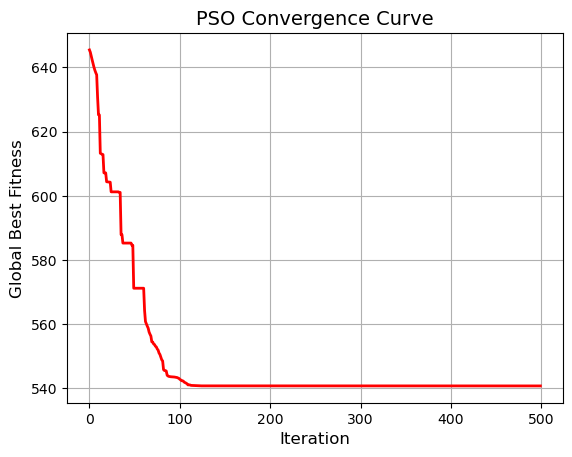

function:
6
Optimized Position: [ 38.73809687  12.82837178 -16.12679584 -29.3678502   24.05896359
  22.18445342 -18.27551334  17.78343717   6.71879568  31.88041492]
Optimized Score: [629.06182971]


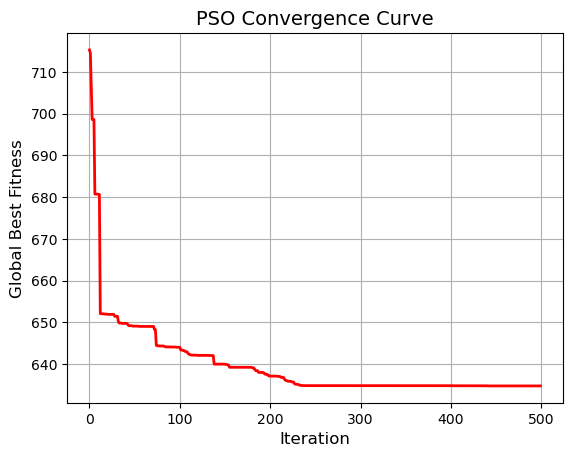

function:
7
Optimized Position: [ -3.3934207   14.72782212  -0.84351847  16.43226959  27.78647918
  -9.38944643  -5.00028502 -10.09942649 -19.60625514  18.3079607
 -13.78445981 -30.95024229 -12.54875689   5.74971596  13.25661489
  13.71447363   0.18074068  -5.50449108 -15.87475355 -15.92947299
 -15.34968833  -3.99577233  21.58941327  16.25650975   9.45491735
 -33.97549583 -16.9352613   -8.56487774   4.8499567    9.76039709]
Optimized Score: [1190.84058448]


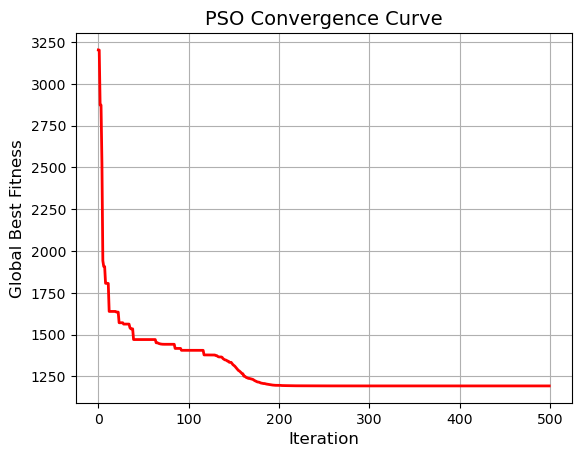

function:
8
Optimized Position: [ -1.90467235  -5.21393344   0.22608862 -31.74850586  -2.14562922
 -30.89655334   8.45807837 -19.31720559  15.1822198  -11.76932473
 -39.68217236  12.08367247  35.16587997 -13.34713674 -12.8697376
 -15.44794241  -8.0418885   -3.24912809  32.84965082  -1.17741499
  29.4187613    7.32477886  -3.47356516 -15.77661229 -18.15210237
 -39.48276355  52.16294621   5.53780225 -43.61123051  25.08867733]
Optimized Score: [923.45045608]


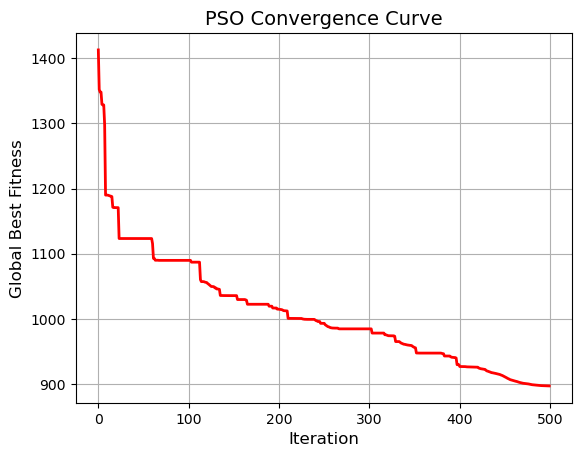

function:
16
Optimized Position: [-1.17028351e+01  5.43439253e+00  2.55566347e+01  2.75786195e+01
 -1.43442430e+01  3.27351991e+01 -1.68273423e+01 -3.54197992e-01
  1.75231085e+01  4.92945413e+01 -5.61249995e-02 -1.64847309e+01
  1.13056258e+01 -5.79292847e+01  3.83896058e+01 -3.41989268e+01
  1.05551016e+01 -1.68932919e+01  1.15447581e+01  1.94436980e+00
 -7.04687169e+01 -7.76989064e+01  9.51886762e+00 -3.10522440e+01
  2.06421689e+00  2.12839174e+01 -1.30236685e+01 -1.98900395e+01
  1.63160060e+01  3.74613969e+01  7.89380260e+00  1.23469280e+01
  1.43305524e+01 -1.71850837e+01 -4.07033734e+01 -6.32254195e+00
 -2.26281692e+01 -1.36837970e+00 -1.29599064e+01  5.31580767e+01
  8.91035232e+00  3.78215803e+01  2.28691154e+01 -4.38382943e+01
 -5.52829114e+01 -2.21183147e+01  5.02285702e+01 -1.82687883e+01
  1.67703248e+01 -2.42048822e+00]
Optimized Score: [4944.89561854]


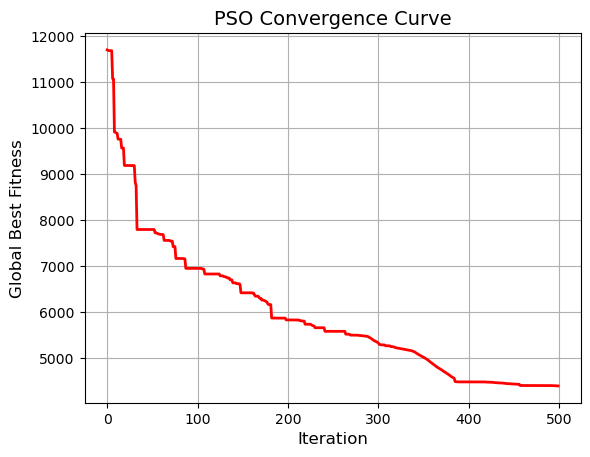

function:
21
Optimized Position: [ 76.9727876  -34.28127804  86.19493741 -42.71692646  20.36031045
  17.3761568  -62.66951954  73.39860693  34.54599629 -30.66256602
  70.16979403  58.76564853  20.46717356 -12.73017901 -68.91116957
 -49.45485339   4.4796426  -34.23236978 -67.10625419 -61.15657692
  36.1571276  -54.24710306 -17.74706257  44.33926516  19.02036769
 -48.74533078 -69.57544164  41.99842999 -17.7137561   42.68045223
  28.80912163 -67.86834561  -2.19025584  58.94590573 -20.74227112
 -65.46040035 -64.7954681   17.9343443   73.83195181 -15.59032364
 -34.03520508 -35.63787049  -7.28039072  20.65847863 -41.47617217
 -59.50883255 -43.97052294   0.34520676 -69.18640842  -6.571639
 -29.13620107  56.3635427  -49.81296579  75.58019924 -58.30309543
  24.83508525  19.09912158  10.13975353 -31.4411007  -41.52773427
  54.35178315 -38.82288466  59.42086062  53.29918623 -37.1216141
  55.63841126  22.12137935  16.41459328 -58.79673281  37.4788744
  -6.9919701   38.57187116  29.05362111 -16.919

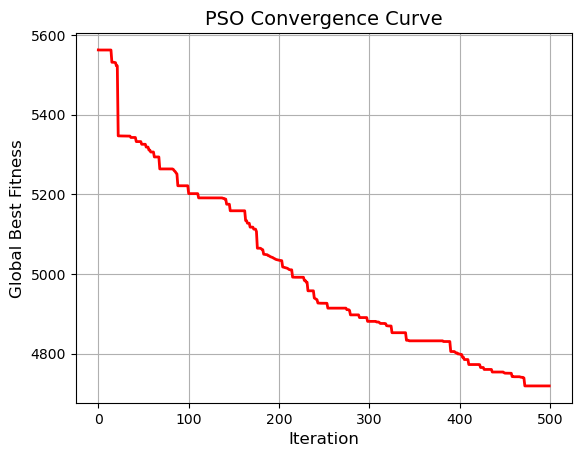

In [4]:
fun_id_list=[5,6,7,8,16,21]
for func_id in fun_id_list:
    MyPSO_gbest_curve=[]
    mean_score=0
    if func_id in [5,6]:
        dim=10
    elif func_id in [7,8]:
        dim=30
    elif func_id in [16,20]:
        dim=50
    else:
        dim=100
    func=all_functions[func_id - 1]
    '''
    problem_dict = {
    "bounds": FloatVar(lb=(-10.,) * dim, ub=(10.,) * dim, name="delta"),
    "minmax": "min",
    "obj_func": func,
    "save_population": True,  # To be able to draw the trajectory figure
    "name": "Square"
    }
    '''
    for j in range(10):
        MyPSO_gbest_history.clear()
        '''
        best_position, best_score = modified_pso(
            func, dim, minx, maxx, n_particles, n_iterations,
            inertia,pm,c1,c2,k_eliminate,attraction_scale=2.0  # 可以调整这个参数来控制信息素衰减速度
        
        best_position, best_score = OriginalTWO.solve(problem_dict)

        best_position, best_score = OriginalCGO.solve(problem_dict)

        best_position, best_score = OriginalSMA.solve(problem_dict)

        best_position, best_score = Original_PSO.solve(problem_dict)
        '''
        best_position, best_score = modified_pso(
            func, dim, minx, maxx, n_particles, n_iterations,
            inertia,pm,c1,c2,k_eliminate,attraction_scale=2.0)  # 可以调整这个参数来控制信息素衰减速度
        MyPSO_gbest_curve.append(MyPSO_gbest_history)
        mean_score+=best_score
    mean_score=mean_score/10
    MyPSO_gbest_curve=np.array(MyPSO_gbest_curve)
    MyPSO_gbest_curve=np.sum(MyPSO_gbest_curve,axis=0)
    MyPSO_gbest_curve/=10
    print("function:")
    print(func_id)
    print("Optimized Position:", best_position)
    print("Optimized Score:", mean_score)
    # 绘制收敛曲线
    plt.plot(MyPSO_gbest_history, 'r-', linewidth=2)
    plt.title('PSO Convergence Curve', fontsize=14)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Global Best Fitness', fontsize=12)
    plt.grid(True)
    plt.show()